## Modelling

Later I'll compile all the other datasets and create notebooks for the EDA, engineering, HP tuning, modelling etc. But for now, we'll just make a blended regression model for just our Blue Nile data.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
plt.rcParams['figure.figsize'] = [12, 7]

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
bn_df = pd.read_csv('input/blue_nile_data.csv')

In [3]:
bn_df.head()

,Shape,Price,Carat,Cut,Color,Clarity,Polish,Symmetry,Fluorescence,Depth,Table,L/W,Price/Ct,Culet,Stock No.,Dispatch Date
0,Emerald,214.8,0.30,Good,I,VS1,Very Good,Very Good,None,68.6,74.0,1.24,716.0,None,LD10955945,Jul 12
1,Pear,219.6,0.31,Very Good,J,SI2,Very Good,Good,Faint,61.8,56.0,1.51,708.0,None,LD12598313,Jul 16
2,Princess,238.8,0.25,Very Good,D,SI1,Excellent,Very Good,None,73.4,73.0,1.05,955.0,None,LD12519682,Jul 12
3,Pear,248.4,0.31,Very Good,G,SI2,Good,Good,None,62.2,64.0,1.62,801.0,None,LD12315077,Jul 16
4,Pear,249.6,0.29,Very Good,E,SI2,Very Good,Good,None,65.7,59.0,1.50,861.0,None,LD12023075,Jul 16


In [4]:
# Convert currency features to floats
bn_df['Price'] = bn_df['Price'].replace('[\£,]', '', regex=True).astype(float)
bn_df['Price/Ct'] = bn_df['Price/Ct'].replace('[\£,]', '', regex=True).astype(float)

C:\Users\Edward Sims\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


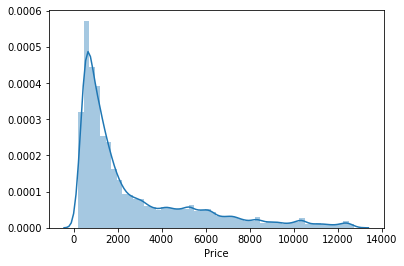

In [5]:
sns.distplot(bn_df['Price'].iloc[0:170000], hist=True)
plt.show()

In [6]:
bn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173725 entries, 0 to 173724
Data columns (total 16 columns):
Shape            173725 non-null object
Price            173725 non-null float64
Carat            173725 non-null float64
Cut              173725 non-null object
Color            173725 non-null object
Clarity          173725 non-null object
Polish           173725 non-null object
Symmetry         173725 non-null object
Fluorescence     173725 non-null object
Depth            173725 non-null float64
Table            173725 non-null float64
L/W              173725 non-null float64
Price/Ct         173725 non-null float64
Culet            173725 non-null object
Stock No.        173725 non-null object
Dispatch Date    173725 non-null object
dtypes: float64(6), object(10)
memory usage: 21.2+ MB


We won't need the `Dispatch Date` and `Stock No`.

In [7]:
bn_df = bn_df.drop(['Stock No.', 'Dispatch Date'], 1)

In [8]:
bn_df.describe()

,Price,Carat,Depth,Table,L/W,Price/Ct
count,1.737250e+05,173725.000000,173725.000000,173725.000000,173725.000000,173725.000000
mean,4.044132e+03,0.721589,63.087385,59.140318,1.061930,3488.371518
std,2.148277e+04,0.572284,3.270146,3.790387,0.156758,3265.017487
min,2.148000e+02,0.230000,51.000000,5.000000,0.800000,708.000000
25%,7.764000e+02,0.400000,61.500000,57.000000,1.000000,1924.000000
50%,1.521600e+03,0.550000,62.400000,58.000000,1.010000,2676.000000
75%,4.138800e+03,1.000000,63.500000,60.000000,1.010000,4293.000000
max,2.127884e+06,20.970000,80.000000,85.000000,3.460000,138444.000000


C:\Users\Edward Sims\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


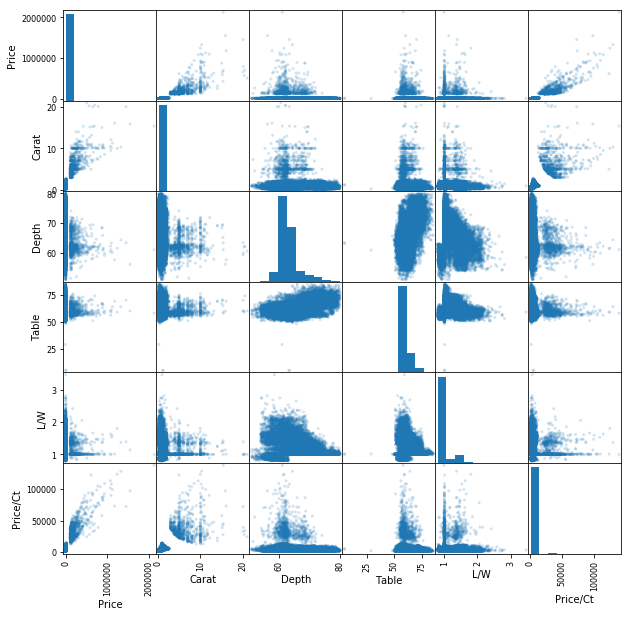

In [9]:
pd.scatter_matrix(bn_df, alpha=0.2, figsize=(10, 10))
plt.show()

In [10]:
bn_df_categorical = bn_df.select_dtypes(include='object')
bn_df_numerical = bn_df.select_dtypes(include='float64')

C:\Users\Edward Sims\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


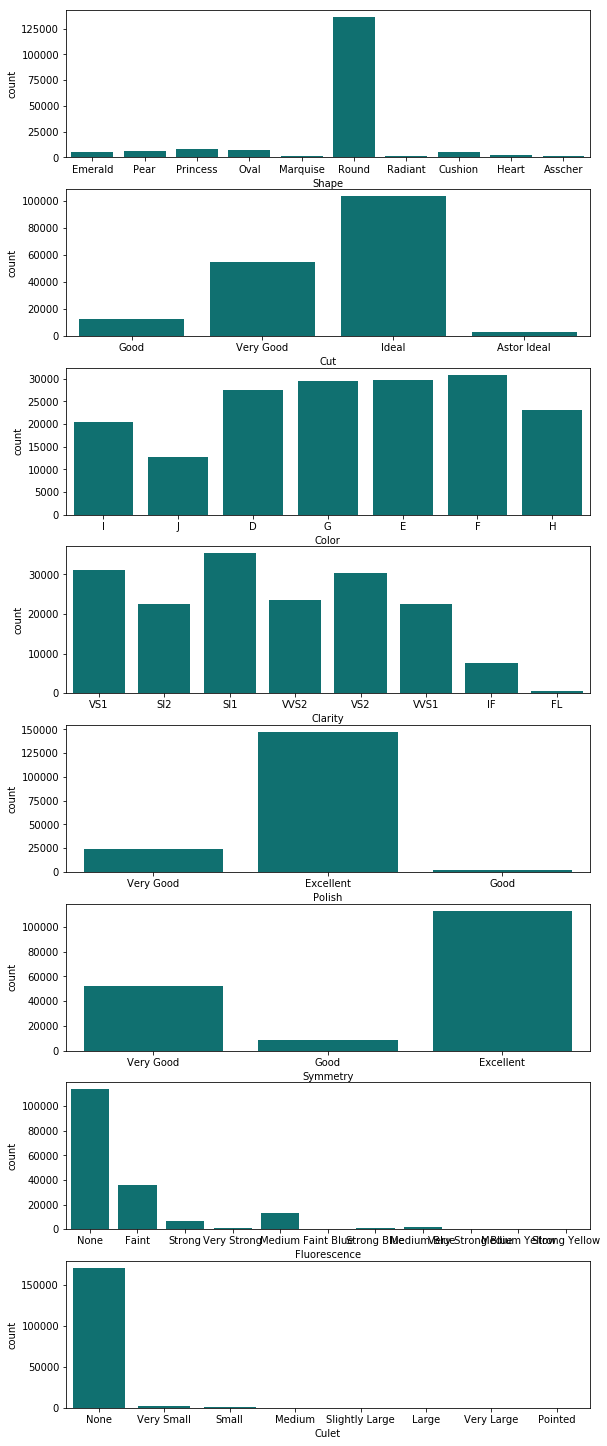

In [11]:
fig, ax = plt.subplots(8,1,figsize = (8,20))
fig.tight_layout()
for i, feature in enumerate(bn_df_categorical.columns):
    plot = sns.countplot(bn_df_categorical[feature], color='teal', ax=ax[i], )
fig.show()

We'll remove the `culet` feature do to a the low variance. 

In [12]:
bn_df = bn_df.drop('Culet', 1)

Next we need to decide what to do with the categorical features - whether to one-hot encode them or map them top some kind of ordinal number. Turns out there are pretty clear scales for all features except fluorescence. We'll one-hot encode this, along with shape.

In [13]:
# Cut
cut_scale_dict = dict(zip(bn_df['Cut'].unique(), [0,1,2,3]))
# Color
color_scale_dict = dict(zip(sorted(bn_df['Color'].unique()), range(0,len(bn_df['Color'].unique()))))
# Clarity - had to do some research for this
clarity_scale_dict = dict(zip(bn_df['Clarity'].unique(), [3,6,5,2,4,1,0,0]))
# Polish
polish_scale_dict = dict(zip(bn_df['Polish'].unique(), [1,2,0]))
# Symmetry
symmetry_scale_dict = dict(zip(bn_df['Symmetry'].unique(), [1,0,2]))

In [14]:
bn_df = bn_df.replace({'Cut': cut_scale_dict})
bn_df = bn_df.replace({'Color': color_scale_dict})
bn_df = bn_df.replace({'Clarity': clarity_scale_dict})
bn_df = bn_df.replace({'Polish': polish_scale_dict})
bn_df = bn_df.replace({'Symmetry': symmetry_scale_dict})
bn_df.head()

,Shape,Price,Carat,Cut,Color,Clarity,Polish,Symmetry,Fluorescence,Depth,Table,L/W,Price/Ct
0,Emerald,214.8,0.30,0,5,3,1,1,None,68.6,74.0,1.24,716.0
1,Pear,219.6,0.31,1,6,6,1,0,Faint,61.8,56.0,1.51,708.0
2,Princess,238.8,0.25,1,0,5,2,1,None,73.4,73.0,1.05,955.0
3,Pear,248.4,0.31,1,3,6,0,0,None,62.2,64.0,1.62,801.0
4,Pear,249.6,0.29,1,1,6,1,0,None,65.7,59.0,1.50,861.0


In [15]:
# lower case all values and replace white spaces with underscores
bn_df['Shape'] = bn_df['Shape'].str.lower()

bn_df['Fluorescence'] = bn_df['Fluorescence'].str.lower()
bn_df['Fluorescence'] = bn_df['Fluorescence'].replace(' ', '_', regex=True)

In [16]:
def dummies(df, columns):
    for column in columns:
        df[column] = df[column].apply(lambda x: str(x))
        df = pd.concat((df, pd.get_dummies(df[column], prefix = column)), axis = 1)
        df = df.drop(column, 1)
    return df

In [17]:
bn_df_final = dummies(bn_df, ['Shape', 'Fluorescence'])

In [18]:
# Due to the high variance, we'll log our price value
bn_df_final['Price'] = np.log1p(bn_df_final["Price"])

In [19]:
bn_df_final.head()

,Price,Carat,Cut,Color,Clarity,Polish,Symmetry,Depth,Table,L/W,...,Fluorescence_faint_blue,Fluorescence_medium,Fluorescence_medium_blue,Fluorescence_medium_yellow,Fluorescence_none,Fluorescence_strong,Fluorescence_strong_blue,Fluorescence_strong_yellow,Fluorescence_very_strong,Fluorescence_very_strong_blue
0,5.374352,0.30,0,5,3,1,1,68.6,74.0,1.24,...,0,0,0,0,1,0,0,0,0,0
1,5.396351,0.31,1,6,6,1,0,61.8,56.0,1.51,...,0,0,0,0,0,0,0,0,0,0
2,5.479805,0.25,1,0,5,2,1,73.4,73.0,1.05,...,0,0,0,0,1,0,0,0,0,0
3,5.519058,0.31,1,3,6,0,0,62.2,64.0,1.62,...,0,0,0,0,1,0,0,0,0,0
4,5.523858,0.29,1,1,6,1,0,65.7,59.0,1.50,...,0,0,0,0,1,0,0,0,0,0


In [20]:
X = bn_df_final.loc[:, bn_df_final.columns != 'Price']
y = bn_df_final['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 10)

In [21]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
print(overfit)
X = X.drop(overfit, axis=1)
print(X.shape)

['Fluorescence_medium_yellow', 'Fluorescence_strong_yellow', 'Fluorescence_very_strong_blue']
(173725, 28)


In [22]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=21)

def rmsle(y, y_pred):
    """
    Return root mean squared logarithmic error
    """
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [23]:
# Define hyperparameters
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [24]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))

lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))

svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [25]:
gbr = GradientBoostingRegressor(n_estimators=3000, 
                                learning_rate=0.05, 
                                max_depth=4, 
                                max_features='auto', 
                                min_samples_leaf=15, 
                                min_samples_split=10, 
                                loss='huber')   

In [26]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=3000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [27]:
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=3000,     
                       max_depth=3, 
                       min_child_weight=0,
                       gamma=0, 
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear', 
                       scale_pos_weight=1,
                       reg_alpha=0.00006)

In [28]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [35]:
score = cv_rmse(ridge)
score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.datetime.now(), )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.datetime.now(), )

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.datetime.now(), )

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.datetime.now(), )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.datetime.now(), )

LASSO: 0.5911 (0.0146)
 2019-07-08 13:06:32.378542
elastic net: 0.5911 (0.0146)
 2019-07-08 13:09:21.601882
SVR: 0.2367 (0.0281)
 2019-07-08 20:15:53.337165
lightgbm: 0.0358 (0.0015)
 2019-07-08 20:18:44.835310
gbr: 0.0058 (0.0011)
 2019-07-08 22:41:38.844274


C:\Users\Edward Sims\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:41:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Edward Sims\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:50:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Edward Sims\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:58:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Edward Sims\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:06:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Edward Sims\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:15:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Edward Sims\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:22:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Edward Sims\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:28:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Edward Sims\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:33:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Edward Sims\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:37:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Edward Sims\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:41:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgboost: 0.0147 (0.0003)
 2019-07-08 23:44:51.316365


In [39]:
print('Start Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X_train), np.array(y_train))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X_train, y_train)

print('Lasso')
lasso_model_full_data = lasso.fit(X_train, y_train)

print('Ridge')
ridge_model_full_data = ridge.fit(X_train, y_train)

print('Svr')
svr_model_full_data = svr.fit(X_train, y_train)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X_train, y_train)

print('xgboost')
xgb_model_full_data = xgboost.fit(X_train, y_train)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X_train, y_train)

Start Fit
stack_gen
[16:02:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:05:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:08:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:19:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
elasticnet
Lasso
Ridge


AttributeError: 'Pipeline' object has no attribute 'fitX_train'

In [ ]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.15 * gbr_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

In [ ]:
print('RMSLE score on train data:')
print(rmsle(y_train, blend_models_predict(X_train)))

In [ ]:
print('RMSLE score on test data:')
print(rmsle(y_test, blend_models_predict(X_test)))